In [52]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
## Load the data set
df = pd.read_pickle('sampled_data_bands.pkl')





df.band.replace('Metallica',0,inplace=True)
df.band.replace('Rush',1,inplace=True)
df.reindex()

X = df.drop(['band','track_name','index'],axis=1)
y = df['band']

X['bpm'] = pd.to_numeric(X['bpm'], errors='coerce').fillna(0)
X['harmonic_rythmic_ratio'] = pd.to_numeric(X['harmonic_rythmic_ratio'], errors='coerce').fillna(0)
X['spectral_centroid'] = pd.to_numeric(X['spectral_centroid'], errors='coerce').fillna(0)
X['spectral_flatness'] = pd.to_numeric(X['spectral_flatness'], errors='coerce').fillna(0)
X['count_delta_above_mean'] = pd.to_numeric(X['count_delta_above_mean'], errors='coerce').fillna(0)
X['ratio_above_rmse_mean'] = pd.to_numeric(X['harmonic_rythmic_ratio'], errors='coerce').fillna(0)
X['max_rmse'] = pd.to_numeric(X['spectral_centroid'], errors='coerce').fillna(0)
X['mean_rms'] = pd.to_numeric(X['spectral_flatness'], errors='coerce').fillna(0)



#np.isnan(y.any()) #and gets False
#and gets True
#X = X.as_matrix().astype(np.float)
#y = y.as_matrix().astype(np.float)

In [53]:
X.head()

,bpm,harmonic_rythmic_ratio,spectral_centroid,spectral_flatness,count_delta_above_mean,ratio_above_rmse_mean,max_rmse,mean_rms,mean_zcr
0,89.102909,3.558330,1686.458521,0.005821,0,3.558330,1686.458521,0.005821,0.07279778079710145
1,129.199219,4.855687,2000.284409,0.013070,12,4.855687,2000.284409,0.013070,0.06671832540760869
2,103.359375,1.316488,2098.202276,0.019428,0,1.316488,2098.202276,0.019428,0.10958767920425258
3,92.285156,1.532198,2545.976752,0.038558,0,1.532198,2545.976752,0.038558,0.14184691775497513
4,161.499023,3.124995,1838.585034,0.013157,0,3.124995,1838.585034,0.013157,0.06252768605025773


In [54]:
### try knn, then write a function to explore the rest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled  = ssX.transform(X_test)

In [4]:
#### KNN Model

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_train_scaled)

In [6]:
####
k_range = list(range(1, 10))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8225444957152275
{'n_neighbors': 6, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')


In [7]:
prediction_hard = grid.predict(X_test_scaled)
actual = y_test
accuracy_score(y_test,prediction_hard)

0.8338972623808059

In [8]:
# confusion matrix

miscount = 0

for index, prediction in enumerate(prediction_hard):
    #print(prediction, actual.iloc[index])
    if prediction != actual.iloc[index]:
        #print(df.iloc[index])
        miscount += 1
        
print(miscount/len(prediction_hard))
## I actually really like the songs it misclassified,
## and I still haven't considered prec/recall balancing
confusion_matrix(y_test,prediction_hard)

0.16610273761919409


array([[1608,  290],
       [ 250, 1103]])

In [9]:
grid.score(X_test_scaled, y_test)

0.8338972623808059

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_scaled)
pcafeatures_train = pca.transform(X_train_scaled)

In [11]:
X.head()

,bpm,harmonic_rythmic_ratio,spectral_centroid,spectral_flatness,count_delta_above_mean,ratio_above_rmse_mean,max_rmse,mean_rms,mean_zcr
0,89.102909,3.558330,1686.458521,0.005821,0,3.558330,1686.458521,0.005821,0.07279778079710145
1,129.199219,4.855687,2000.284409,0.013070,12,4.855687,2000.284409,0.013070,0.06671832540760869
2,103.359375,1.316488,2098.202276,0.019428,0,1.316488,2098.202276,0.019428,0.10958767920425258
3,92.285156,1.532198,2545.976752,0.038558,0,1.532198,2545.976752,0.038558,0.14184691775497513
4,161.499023,3.124995,1838.585034,0.013157,0,3.124995,1838.585034,0.013157,0.06252768605025773


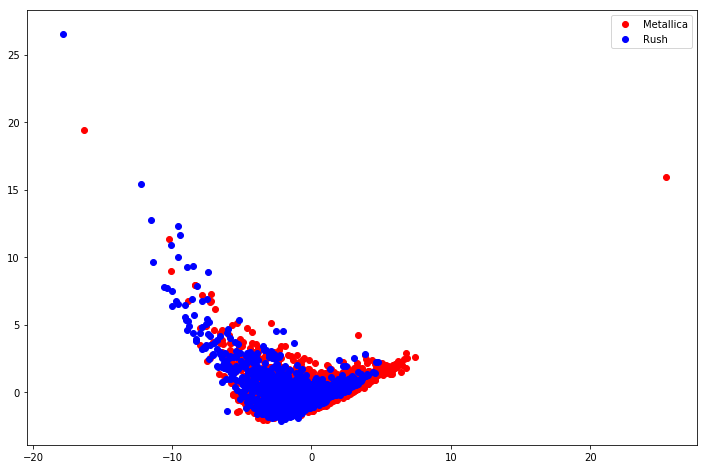

In [12]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','b','g','c','m','y','orange','k','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    plt.legend()

    
plot_PCA_2D(pcafeatures_train, target=y_train.astype(int), target_names=['Metallica', 'Rush'])
plt.gcf().set_size_inches(12,8)
    

In [13]:
from sklearn.manifold import TSNE

Xsne = TSNE(n_components=2,perplexity=100.0).fit_transform(X_train_scaled[:1000,:])


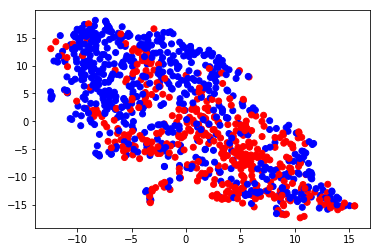

In [14]:
plt.scatter(Xsne[:,0],Xsne[:,1],c=['r' if band==1 else 'b' for band in y_train])

In [15]:
#import seaborn as sns; sns.set(font_scale=1.2)
#sns.pairplot(df, hue='band')

In [16]:
### Try Logisitic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

lm1 = LogisticRegression(C=1000)
lm1.fit(X_train_scaled, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
lm1.score(X_train_scaled, y_train) 

0.6970336189848385

In [19]:
prediction_hard = lm1.predict(X_test_scaled)
actual = y_test
# check accuracy
accuracy_score(y_test,prediction_hard)

0.7065518302060905

In [20]:
miscount = 0
for index, prediction in enumerate(prediction_hard):
    #print(prediction, actual.iloc[index])
    if prediction != actual.iloc[index]:
        #print(df.iloc[index])
        miscount += 1
        
miscount/len(prediction_hard)
### Actually those two songs I really like, I really like them.
### So my features don't really captures the ones I really, really like 
### yet...... but logistic regression does pretty weel

0.2934481697939096

In [56]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#svc = SVC(probability=True)
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('svm', SVC)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12),
        'weights': ['uniform', 'distance']
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
       'n_estimators': [50, 100, 200],
       'max_depth': [1,2,3,4,5],
       'min_samples_leaf': [3,6,10]
    },
    {
        'C': [1, 5, 10, 50,100], 
        'kernel': ['linear','poly','rbf'] ,
        'probability': [True]
    },
 
]
    
    


grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train_scaled, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

knn: best score: 0.8104152933421226
logistic: best score: 0.6957152274225445
tree: best score: 0.7596572181938036


In [28]:
# Let's get the testing score
grids['svm'].best_estimator_.score(X_test_scaled, y_test)

0.824669332513073

In [29]:
grids['svm'].best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
#import seaborn as sns; sns.set(font_scale=1.2)
#sns.pairplot(df.drop('index',axis=1), hue='band')

In [31]:
prediction_hard = grids['svm'].best_estimator_.predict(X_test_scaled)
actual = y_test
accuracy_score(y_test,prediction_hard)

0.824669332513073

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(grids['svm'], X_train_scaled, y_train, cv = 10)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

In [48]:
%%time
## Tune the hyper parameters of svm if possible and refit!

models = [('svm',SVC)]

gamma_range = np.logspace(-2, 0, 5)
C_range = np.logspace(1.75,2.5,5)

param_choices = [

   {
       'C': C_range, 
       'kernel': ['rbf'],
       'gamma': gamma_range,
       'probability': [True]
   },
 
]
grids = {}
for model_info, params in zip(models, param_choices):
   name, model = model_info
   print(name,model)
   grid = GridSearchCV(model(), params)
   grid.fit(X_train_scaled, y_train)
   s = f"{name}: best score: {grid.best_score_}"
   print(s)
   grids[name] = grid

svm <class 'sklearn.svm.classes.SVC'>
svm: best score: 0.8176664469347397
CPU times: user 11min 2s, sys: 3.08 s, total: 11min 5s
Wall time: 11min 6s


In [49]:
prediction_hard = grids['svm'].best_estimator_.predict(X_test_scaled)
actual = y_test
accuracy_score(y_test,prediction_hard) #BETTER!

0.8305136880959705

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(grids['svm'], X_train_scaled, y_train, cv = 10)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

In [33]:
## find which features separate the most...?? of the ones that mis-classify, 
## what is having the most trouble
### do other approach... then get two proba
#### logisitic regression with the proba

In [50]:
## EXPORT MODEL 1
from sklearn.pipeline import Pipeline
import pickle

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('svm', SVC(**grids['svm'].best_params_))])
pipeline.fit(X_train,y_train)
pickle.dump(pipeline, open('model.pkl', 'wb'))

test_data = [X_test,y_test]
pickle.dump(test_data,open('test_data.pkl','wb'))

In [51]:
train_data = [X_train,y_train]
pickle.dump(train_data,open('training_data.pkl','wb'))